In [1]:
# package to store and manipulate neural-network input and output data
import numpy as np

# package to graphically display any data
import matplotlib.pyplot as plt

# package to manipulate neural-network models
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader, random_split
from torch.utils.data import TensorDataset

# packages for templating ANN code
import pytorch_lightning as pl

from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.utilities import rank_zero_only
from pytorch_lightning.loggers import LightningLoggerBase

In [2]:
#if notebook is runned in Google Colab, you may need to install PL
#!pip install pytorch_lightning

In [3]:
# remove preexisting traces
#!rm -rf lightning_logs

In [4]:
print("Pytorch version:", torch.__version__)
print("Pytorch Lightning version:", pl.__version__)

Pytorch version: 1.5.1
Pytorch Lightning version: 0.8.4


In [5]:
if torch.cuda.is_available():
  print('GPU support (%s)' % torch.cuda.get_device_name(0))
else:
  print('no GPU support')

GPU support (GeForce RTX 2080 Ti)


In [7]:
class FooNet(pl.LightningModule):

  def __init__(self):
    super().__init__()
    self.layer_1 = torch.nn.Linear(1, 8)
    self.layer_2 = torch.nn.Linear(8, 1)

    self.X_train = np.array([0.765,0.838,0.329,0.277,0.45,0.833,0.44,0.634,0.351,0.784,0.589,0.816,0.352,0.591,0.04,0.38,0.816,0.732,0.32,0.597,0.908,0.146,0.691,0.75,0.568,0.866,0.705,0.027,0.607,0.793,0.864,0.057,0.877,0.164,0.729,0.291,0.324,0.745,0.158,0.098,0.113,0.794,0.452,0.765,0.983,0.001,0.474,0.773,0.155,0.875,])
    self.Y_train = np.array([6.322,6.264,3.224,2.97,4.167,6.267,4.088,5.727,3.379,6.334,5.381,6.306,3.189,5.4,1.704,3.602,6.306,6.254,3.157,5.446,5.918,2.147,6.088,6.298,5.204,6.147,6.153,1.653,5.527,6.332,6.156,1.766,6.098,2.236,6.244,2.96,3.183,6.287,2.205,1.934,1.996,6.331,4.188,6.322,5.368,1.561,4.383,6.33,2.192,6.108,])
    
    self.X_eval = np.array([0.329,0.528,0.323,0.952,0.868,0.931,0.69,0.112,0.574,0.421,0.972,0.715,0.7,0.58,0.69,0.163,0.093,0.695,0.493,0.243,0.928,0.409,0.619,0.011,0.218,0.647,0.499,0.354,0.064,0.571,0.836,0.068,0.451,0.074,0.158,0.571,0.754,0.259,0.035,0.595,0.245,0.929,0.546,0.901,0.822,0.797,0.089,0.924,0.903,0.334,])
    self.Y_eval = np.array([3.221,4.858,3.176,5.617,6.141,5.769,6.081,1.995,5.259,3.932,5.458,6.193,6.129,5.305,6.081,2.228,1.912,6.106,4.547,2.665,5.791,3.829,5.619,1.598,2.518,5.826,4.603,3.405,1.794,5.23,6.26,1.81,4.18,1.832,2.208,5.234,6.306,2.759,1.684,5.432,2.673,5.781,5.019,5.965,6.295,6.329,1.894,5.816,5.951,3.258,])
    
    self.X_test = np.array([0., 0.2, 0.4, 0.6, 0.8, 1.0])
    self.Y_test = np.tan(np.sin(self.X_test) + np.cos(self.X_test)) 

    
  def forward(self, x):
    #x = x.view(1, -1)
    x = self.layer_1(x)
    x = torch.nn.functional.relu(x)
    x = self.layer_2(x)
    return(x)
      
  def train_dataloader(self):
    
    X_train2 = torch.from_numpy(self.X_train).unsqueeze(1).float()
    Y_train2 = torch.from_numpy(self.Y_train).unsqueeze(1).float()

    dataset = TensorDataset(X_train2, Y_train2)
    return DataLoader(dataset, num_workers=28, batch_size=1)

  def val_dataloader(self):
    
    X_eval2 = torch.from_numpy(self.X_eval).unsqueeze(1).float()
    Y_eval2 = torch.from_numpy(self.Y_eval).unsqueeze(1).float()

    dataset = TensorDataset(X_eval2, Y_eval2)
    return DataLoader(dataset, num_workers=28, batch_size=1)

  def test_dataloader(self):
    
    X_test2 = torch.from_numpy(self.X_test).unsqueeze(1).float()
    Y_test2 = torch.from_numpy(self.Y_test).unsqueeze(1).float()

    dataset = TensorDataset(X_test2, Y_test2)
    return DataLoader(dataset, num_workers=28, batch_size=1)

  def configure_optimizers(self):
    optimizer = optim.Adam(self.parameters(), lr=0.02)
    return optimizer

  # optional
  def mse_loss(self, output, target):
    mean_squared_error = torch.sum((output - target) ** 2)/target.shape[0]
    return mean_squared_error

  def training_step(self, train_batch, batch_nb):
    
    x, target = train_batch
    output = self.forward(x)
    loss = self.mse_loss(output, target)
    logs = {'train_loss': loss}
    return {'loss': loss, 'log': logs}
    
  def validation_step(self, valid_batch, batch_nb):
  
    x, target = valid_batch
    output = self.forward(x)
    loss = self.mse_loss(output, target)
    logs = {'val_loss': loss}
    return {'val_loss': loss, 'log': logs}

  def validation_epoch_end(self, outputs):
    val_loss_mean = torch.stack([x['val_loss'] for x in outputs]).mean()
    return {'val_loss': val_loss_mean}

  def test_step(self, test_batch, batch_nb):
  
    x, target = test_batch
    output = self.forward(x)
    loss = self.mse_loss(output, target)
    return {'test_loss': loss}

In [8]:
# default used by the Trainer
early_stopping = EarlyStopping(
    monitor='val_loss',    
    mode='min',
    patience=10,
    strict=True,
    verbose=False,
)

In [10]:
model = FooNet()

# There is currently a bug with PL and underlying tqdm package
# with displays "HBox(children=..." lines instead of progress bar :-(
# in order to avoid it, you need to install jupyter lab extension
# jupyter nbextension enable --py widgetsnbextension

# look at all possible *training* options at:
# https://pytorch-lightning.readthedocs.io/en/latest/trainer.html
trainer = pl.Trainer(max_epochs=20000, check_val_every_n_epoch=1, early_stop_callback=early_stopping)
#trainer = pl.Trainer(distributed_backend='dp', gpus=2, max_epochs=20000, check_val_every_n_epoch=1, early_stop_callback=early_stopping)
#, logger=my_logger)

trainer.fit(model)

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
/home/arc/.local/lib/python3.6/site-packages/pytorch_lightning/utilities/distributed.py:25: RuntimeWarning: You have defined a `test_dataloader()` and have defined a `test_step()`, you may also want to define `test_epoch_end()` for accumulating stats.
  warnings.warn(*args, **kwargs)

  | Name    | Type   | Params
-----------------------------------
0 | layer_1 | Linear | 16    
1 | layer_2 | Linear | 9     


1

In [11]:
%reload_ext tensorboard
%tensorboard --logdir lightning_logs/

Reusing TensorBoard on port 6006 (pid 11162), started 0:01:26 ago. (Use '!kill 11162' to kill it.)

In [12]:
samples = np.array([0., 0.2, 0.4, 0.6, 0.8, 1.0])
samples = torch.from_numpy(samples).unsqueeze(1).float()
test_results = model(samples)
test_results

tensor([[1.3905],
        [2.7458],
        [4.1010],
        [5.4563],
        [6.1406],
        [6.1212]], grad_fn=<AddmmBackward>)

In [13]:
test_results.shape

torch.Size([6, 1])

In [14]:
test_results[0][0]

tensor(1.3905, grad_fn=<SelectBackward>)

In [15]:
Y_predicted_values = []
i = 0
for i in range(test_results.shape[0]):
    val  = test_results[i][0].detach().numpy()
    Y_predicted_values.append(val)

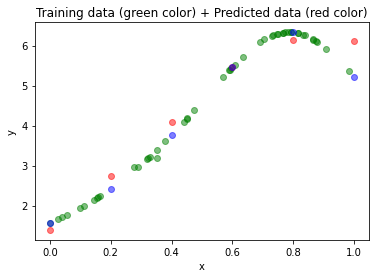

In [16]:
# Display training data and predicted data graphically
plt.title('Training data (green color) + Predicted data (red color)')

# training data in green color
plt.scatter(model.X_train, model.Y_train, color='green',  alpha=0.5)

# training data in green color
#plt.scatter(X_test, Y_test, color='blue',  alpha=0.5)

# predicted data in blue color
plt.scatter(model.X_test, Y_predicted_values, color='red',  alpha=0.5)
plt.scatter(model.X_test, model.Y_test, color='blue',  alpha=0.5)
#plt.scatter(model.X_test, predictions_actual[0].numpy() , color='green',  alpha=0.5)

plt.xlabel('x')
plt.ylabel('y')
plt.show()